# COMPONENTES DE TIME SERIES

Paqueterías:

In [1]:
#Las paqueterías más usadas en ciencia de datos con Python son:

import pandas as pd  #para analisis de datos
import numpy as np   #para calculos numericos
import matplotlib.pyplot as plt  #para graficos
import seaborn as sns #para graficos estadisticos

## Dataset

A partir de ahora vamos a usar datasets de github, ya que es más practico y no es necesario descargar la base de datos

In [ ]:
link="https://raw.githubusercontent.com/SergioDP94/Forecasting/refs/heads/main/data/analisis_serie.csv"
data=pd.read_csv(link,index_col=0) 
data.info()
data.columns # El index es de tipo object, no de tipo fecha
#Esta forma hace que el index no tenga un formato de fecha

<class 'pandas.core.frame.DataFrame'>
Index: 137 entries, 2024-01-01 to 2024-05-16
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ventas  137 non-null    float64
dtypes: float64(1)
memory usage: 2.1+ KB


Index(['ventas'], dtype='object')

Dando formato de fecha al index :

In [7]:
data2=pd.read_csv(link,parse_dates=True,index_col=0)
data2.info()
data2.columns

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 137 entries, 2024-01-01 to 2024-05-16
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ventas  137 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


Index(['ventas'], dtype='object')

## Gráficos

Vamos a realizar algunos gráficos para explorar el dataset

<Axes: >

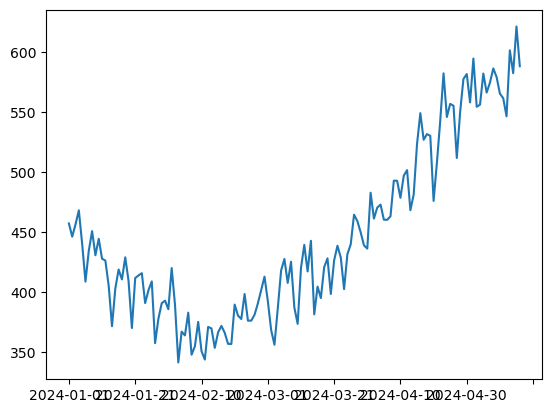

In [10]:
data.ventas.plot() 
#Esta grafica no tiene formato de serie de 
# tiempo porque el index no es de tipo fecha

<Axes: >

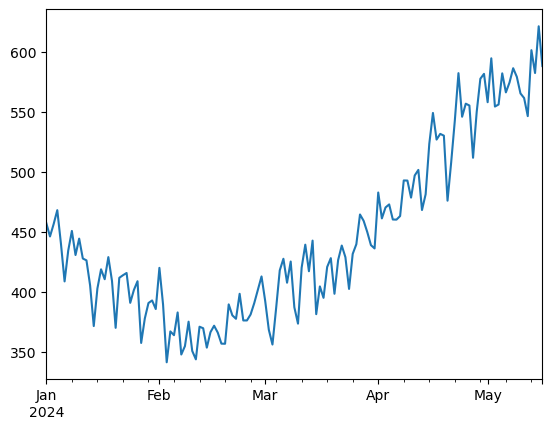

In [11]:
#En cambio cuando usamos data2 con parse_dates=True, 
#Si tiene formato de serie de tiempo
data2.ventas.plot()

Otra ventaja de usar parse_dates=True es que al hacer forecasting, dichas predicciones tendrán una fecha asignada (tendrán un indice)

## Análisis exploratorio

In [14]:
#Principales estadisticos descriptivos de la serie
data.describe()

,ventas
count,137.000000
mean,446.573949
std,72.415699
min,341.634336
25%,389.861260
50%,428.048735
75%,492.981193
max,621.484310


Los estadísticos descriptivos en time series pueden ser algo engañosos. Si asumimos una tendencia creciente, entonces el minimo sería el comienzo de la serie, lo cual, para nuestra serie que tiene cambios de tendencia, es totalmente incorrecto.

Las series tienen tendencia y estacionalidad. Para poder hallar el comportamiento de uno, es necesario aislarlo del otro. Ejm: 
 - Si se quiere analizar la tendencia, hay que quitar la estacionalidad
 - Si se quiere analizar la estacionalidad, 1ero hay que quitar la tendencia

## Tendencia

### Media movil (SMA)

Es la primera forma que vamos a evaluar la tendencia. La media movil(n) es el promedio de los n datos anteriores. (Funciona como un filtro, porque suaviza las series)

NOTA: diferenciar media movil del modelo de medias moviles MA(q). Este es un proceso aleatorio que es la suma  de los "q" errores aleatorios rezagados más el error aleatorio en t. (Es un concepto más de estadística y econometría)

Para las media movil, por lo general se suele emplear la frecuencia con que se van a repetir los datos. 
- Ventas diarias: se emplea media movil de 7 días
- datos mensuales : Patrones cada 12 meses
- Datos por hora :  patrones cada 24 horas

In [18]:
data2.ventas.rolling(window=7).mean()
#El comando .rolling(window=7) agrupa los datos en ventanas de 7 observaciones
#y el .mean() calcula el promedio de cada ventana (7 datos)

2024-01-01           NaN
2024-01-02           NaN
2024-01-03           NaN
2024-01-04           NaN
2024-01-05           NaN
                 ...    
2024-05-12    568.716043
2024-05-13    573.735814
2024-05-14    574.861468
2024-05-15    579.851570
2024-05-16    581.134399
Name: ventas, Length: 137, dtype: float64

Ahora a dicha serie mostrada, vamos a guardarla como una nueva columna

In [ ]:
data2["MA_7"]=data2.ventas.rolling(window=7).mean()

realizando el grafico de series de tiempo a las ventas y su promedio movil :

<Axes: >

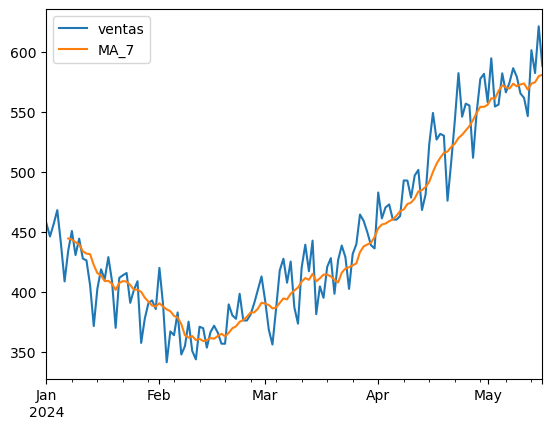

In [24]:
data2.plot()

Tambien podemos crear una tendencia de corto plazo, pero como el suavizado será con una menor cantidad de datos, el promedio movil será más ruidoso:

In [25]:
data2["MA_5"]=data2.ventas.rolling(window=5).mean()

Graficando las tendencias de CP y LP:

<Axes: >

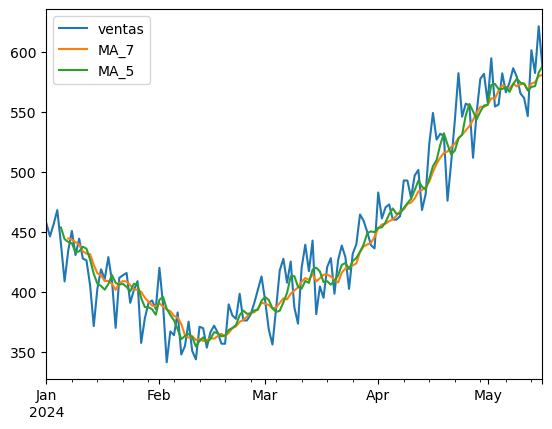

In [26]:
data2.plot()

Ahora vamos a añadir un promedio movil de 9 días. Graficamente se verá que es más ruidoso que para 7 días. Esto ocurre porque a mayor longitud de datos a promediar, el promedio movil captura más estacionalidades y se vuelve más ruidos. Aqui radica la importancia de elegir bien la cantidad de rezagos a considerar

In [27]:
data2["MA_9"]=data2.ventas.rolling(window=9).mean()

<Axes: >

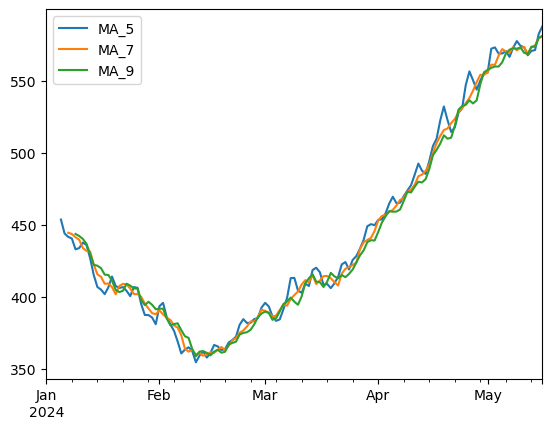

In [31]:
data2[["MA_5","MA_7","MA_9"]].plot()

<Axes: >

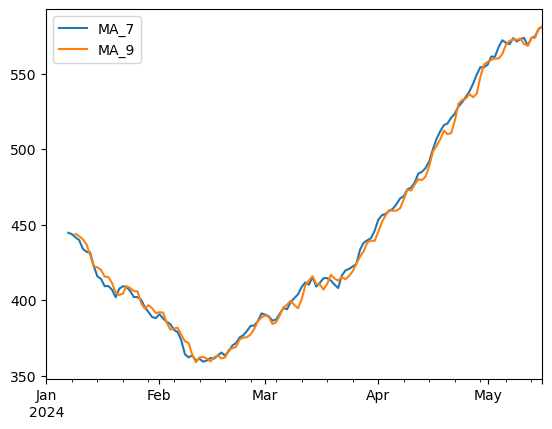

In [32]:
data2[["MA_7","MA_9"]].plot()

MA_7 es menos fluctuante que MA_9

### Suavizamiento exponencial ponderado (EWMA)

Este filtrado realiza un suavizamiento exponencial, donde, para los datos más recientes, les dá mayor peso a las observaciones cercanas que a las antiguas

Para no crear todas las variables en nuestro data, mejor vamos a correrlas en el grafico  (más codigo)

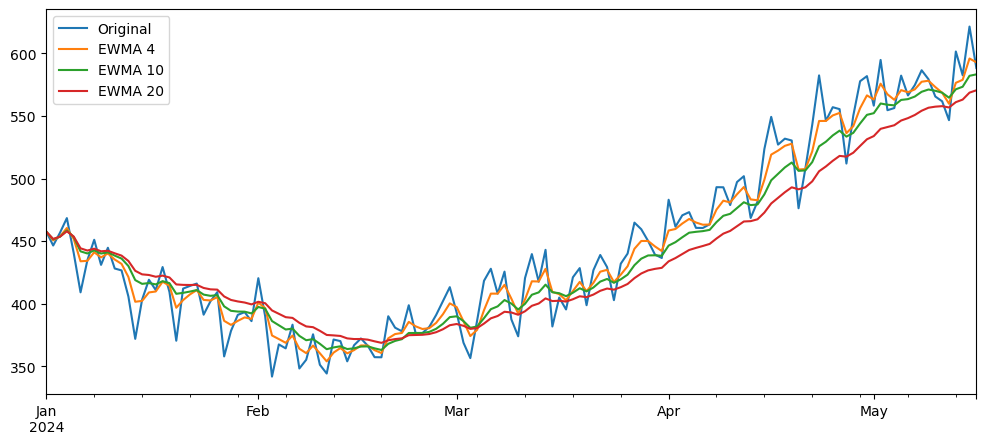

In [36]:
data2.ventas.plot(label="Original",figsize=(12,5)) #Figsize es el tamaño del grafico
data2.ventas.ewm(span=4).mean().plot(label="EWMA 4") #EWMA: Exponential Weighted Moving Average
data2.ventas.ewm(span=10).mean().plot(label="EWMA 10") 
data2.ventas.ewm(span=20).mean().plot(label="EWMA 20")
plt.legend()  #Para que aparezca la leyenda en el grafico

#Aqui ewm es para aplicar el filtro del promedio movil exponencialmente ponderado

A medida que aumentamos las ventanas, el suavizado tiende a aplanar mucho la serie, por lo que se despega mucho de la tendencia real. el SPAN dentro del filtro significa las ventanas pasadas a las que el filtro les dará la mayor ponderación (el pasado inmediato más relevante)

El EWMA no suavisa tan bien las series como SMA, porque al componente estacional lo atribuye como el error que intenta suavizar, por ello el EWMA tiene dichos picos en la serie.

### Tendencia LOESS (o LOWESS)

Es un suavizado local que ajusta pequeños modelos de regresion en diversos tramos de datos. A deiferencia de los promedios, no asume una forma lineal y se adapta mejor a los cambios no lineales.

*Ventaja* :
 - Permite capturar bien las curvas suaves o cambios graduales sin necesidad de tener un modelo global

Para este modelo, vamos a usar una paquetería especifica:

In [40]:
from statsmodels.nonparametric.smoothers_lowess import lowess

loess=lowess(data2["ventas"],np.arange(len(data2)),frac=0.1)
#El comando accede a "ventas", luego crear un arreglo de numeros secuenciales,
#toma una fraccion del 10% de los datos más cercanos para suavizar

#El conando crear una lista de tuplas : con el indice arange y los valores suavizados
print(loess)


[[  0.         456.92364016]
 [  1.         454.00279212]
 [  2.         451.12934625]
 [  3.         448.38020262]
 [  4.         445.81068341]
 [  5.         443.3193477 ]
 [  6.         440.42732883]
 [  7.         437.16103653]
 [  8.         433.88718175]
 [  9.         430.42427958]
 [ 10.         425.87275811]
 [ 11.         421.47619783]
 [ 12.         417.94209638]
 [ 13.         415.37999476]
 [ 14.         413.10984838]
 [ 15.         411.31403337]
 [ 16.         410.6689395 ]
 [ 17.         411.21680709]
 [ 18.         411.77008494]
 [ 19.         411.02557014]
 [ 20.         409.22626572]
 [ 21.         407.17417898]
 [ 22.         404.73840583]
 [ 23.         401.73401289]
 [ 24.         398.22919135]
 [ 25.         394.99250454]
 [ 26.         392.37804003]
 [ 27.         390.75673749]
 [ 28.         389.69471832]
 [ 29.         387.97149238]
 [ 30.         385.54573747]
 [ 31.         382.98290687]
 [ 32.         380.37537669]
 [ 33.         376.83989778]
 [ 34.        

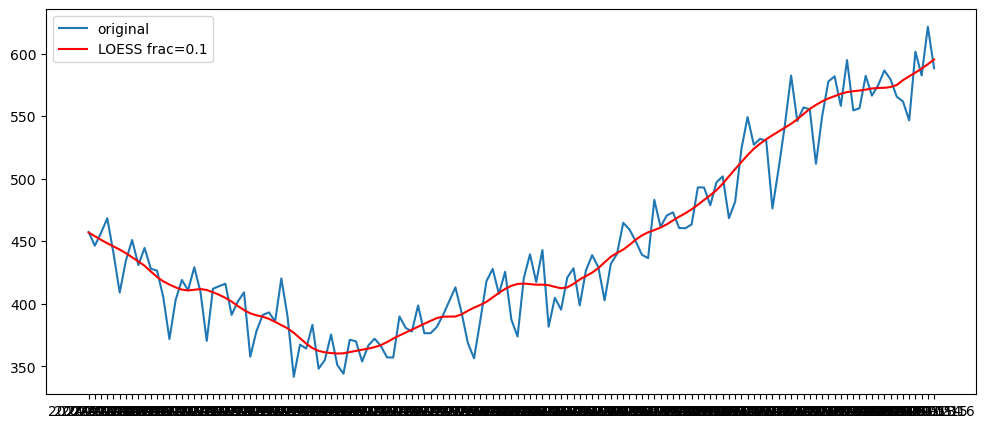

In [41]:
fig,ax=plt.subplots(figsize=(12,5)) #Crea una figura y configura el grafico
plt.plot(data.index, data["ventas"], label= "original") #Grafica los datos originales 
plt.plot(data.index, loess[:,1], color="red", label="LOESS frac=0.1") #Añadimos la serie suavisada
plt.legend()  #Añade la leyenda al grafico
plt.show()  #Muestra el grafico